In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

2022-11-29 20:00:56.485106: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df_american = pd.read_excel(r'/Users/dilianaserafimova/Desktop/American_Airlines_clean.xlsx')

In [5]:
df_american.head()

,date,pax_count,revenue,seat_miles,load_factor,flights
0,2003-01-01,7013818,9405547,14038698,67.00,78214
1,2003-02-01,6363926,8355084,12142241,68.81,67463
2,2003-03-01,7628481,9981627,13929984,71.66,77125
3,2003-04-01,7103085,9325622,13210596,70.59,73182
4,2003-05-01,7447462,9838460,13345197,73.72,73381


## Only 1 feature 

In [6]:
paxes = df_american['pax_count']

In [7]:
paxes.head()

0    7013818
1    6363926
2    7628481
3    7103085
4    7447462
Name: pax_count, dtype: int64

## Convert pandas dataframe to numpy array

In [8]:
dataset = paxes.values
#dateset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)

## Normalization

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

## Split the data

In [10]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [11]:
print (train_size)

163


In [12]:
print(test_size)

41


# Feed Forward Neural Network

In [13]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []
    
    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size,0])
    return np.array(x), np.array(y)

In [14]:
seq_size = 12

In [16]:
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [17]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (150, 12)
Shape of test set: (28, 12)


In [18]:
print(len(testY))

28


## Creat and fit dense model

### Specify the structure of a neural network 

In [19]:
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation = 'relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

2022-11-29 20:01:55.100532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compile the keras model 

In [20]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________
None


### Fit keras model on the dataset 

In [39]:
model.fit(trainX, trainY, validation_data=(testX, testY),
         verbose=0, epochs=100)

### Make predictions

In [40]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

1/1 [==============================] - 0s 27ms/step


### Invert normalization

In [41]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [42]:
print(len(trainPredict))

150


In [43]:
print(len(testPredict))

28


### RMSE 

In [44]:
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0],trainPredict[:,0]))
print("Train Score: %.2f RMSE" % (trainScore))

Train Score: 357429.79 RMSE


In [45]:
testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print("Test Score: %.2f RMSE" % (testScore))

Test Score: 572711.06 RMSE


### Shift train predictions for plotting

In [29]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+(seq_size),:] = trainPredict

### Shift test predictions for plotting

In [30]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1,:]= testPredict

# Visualization

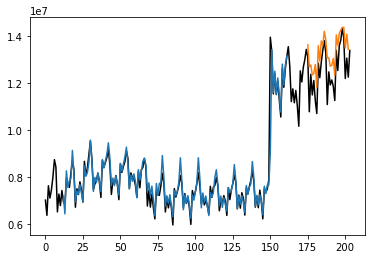

In [31]:
plt.plot(scaler.inverse_transform(dataset), color='black')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [46]:
%cd  /Users/dilianaserafimova/Library/Mobile Documents/com~apple~CloudDocs/Documents/My Files/Master Studium/Masterarbeit/Forecast/American Airlines

/Users/dilianaserafimova/Library/Mobile Documents/com~apple~CloudDocs/Documents/My Files/Master Studium/Masterarbeit/Forecast/American Airlines


In [47]:
testY_inverse.tofile('predictions_ffnn.csv', sep = ',')